<a href="https://colab.research.google.com/github/rexbrandy/cifar10_classification/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DataLoaders

In [17]:
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
MODEL_PATH = './cifar_net2.pth'

cuda:0


In [6]:
def get_dataloaders(batch_size=5, show_images=True):

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    train_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    if show_images:
        visualize_data(train_dataset)

    return train_dataloader, test_dataloader

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(training_data):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 5, 1
    for i in range(1, cols * rows + 1):

        sample_idx = torch.randint(len(training_data), size=(1,)).item()

        img, label = training_data[sample_idx]

        figure.add_subplot(rows, cols, i)
        plt.title(CLASSES[label])
        plt.axis("off")

        img = img / 2 + 0.5
        np_img = np.transpose(img, (1, 2, 0))
        plt.imshow(np_img)
    plt.show()

def imshow(test_dataloader):
    images, labels = next(iter(test_dataloader))

    # print images
    img = torchvision.utils.make_grid(images)

    print('GroundTruth: ', ' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(4)))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Models

In this model we will implement a convolutional neural network that is used to process the images.

In this network we feed the the input first through a convolution layer then a max pooling layer and then a second convolution layer, after this it is fed through 3 linear layers.

## Convolution Layer

Convolution layers apply filters to the image that help highlight specific details that may be important during the classification task. In the following gif you can see how a convolution layer is applied to a matrix.

![Convolution](https://miro.medium.com/v2/resize:fit:400/format:webp/1*rRT3tkMOKX-8c7nqW_iHLQ.gif)

## Max pooling

Max pooling effects the image by taking groups of pixel and aggregating them together to get a reduced version of the image that retains the important features.

![Max pooling](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*76nyDxRFl2ZUseO6ymEXAw.png)

## Calculating convolution and max pooling

To calculate the output of convolution and pooling layers we use this formula

**[(W−K+2P)/S]+1**

W is the input volume

K is the Kernel size

P is the padding

S is the stride



In [31]:
import torch
from torch import nn
from torch.nn import functional as f

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutions
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Feed forward
        '''
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        '''

        self.fc1 = nn.Linear(16 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, 240)
        self.fc3 = nn.Linear(240, 60)
        self.fc4 = nn.Linear(60, 10)


    def forward(self, x):
        output = self.pool(f.relu(self.conv1(x)))
        output = self.pool(f.relu(self.conv2(output)))

        output = torch.flatten(output, 1) # flatten all dimensions except batch size

        output = f.relu(self.fc1(output))
        output = f.relu(self.fc2(output))
        output = f.relu(self.fc3(output))
        output = self.fc4(output)
        return output



# Training

In [28]:
def train(n_epochs, train_dataloader, cnn, optim, criterion, save_model=True):
    best_loss = 100

    for epoch in range(n_epochs):
        running_loss = 0.0

        for i, batch in enumerate(train_dataloader):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optim.zero_grad()
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optim.step()

            running_loss += loss.item()

            if save_model and loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(cnn.state_dict(), MODEL_PATH)

            if i % 2000 == 1999:
                print(f'Epoch: {epoch} Batch: {i+1} Loss: {running_loss/2000:.3f}')
                running_loss = 0
    print()


# Evaluate

In [19]:
def test(test_dataloader, cnn):
    correct = {classname: 0 for classname in CLASSES}
    total = {classname: 0 for classname in CLASSES}

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels

            outputs = cnn(inputs)
            _, predictions = torch.max(outputs, 1)

            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct[CLASSES[label]] += 1
                total[CLASSES[label]] += 1

        # print accuracy for each class
        for classname, correct_count in correct.items():
            accuracy = 100 * float(correct_count) / total[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    print(f'Total Accuracy: {}')


# Main Loop

Files already downloaded and verified
Files already downloaded and verified


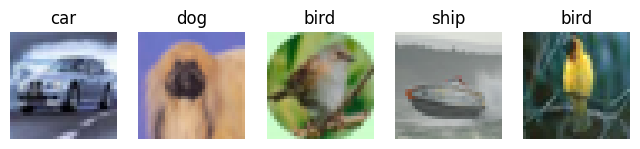

Epoch: 0 Batch: 2000 Loss: 2.302
Epoch: 0 Batch: 4000 Loss: 2.164
Epoch: 0 Batch: 6000 Loss: 1.859
Epoch: 0 Batch: 8000 Loss: 1.677
Epoch: 0 Batch: 10000 Loss: 1.584
Epoch: 1 Batch: 2000 Loss: 1.503
Epoch: 1 Batch: 4000 Loss: 1.461
Epoch: 1 Batch: 6000 Loss: 1.405
Epoch: 1 Batch: 8000 Loss: 1.397
Epoch: 1 Batch: 10000 Loss: 1.348
Epoch: 2 Batch: 2000 Loss: 1.289
Epoch: 2 Batch: 4000 Loss: 1.268
Epoch: 2 Batch: 6000 Loss: 1.236
Epoch: 2 Batch: 8000 Loss: 1.218
Epoch: 2 Batch: 10000 Loss: 1.193
Epoch: 3 Batch: 2000 Loss: 1.110
Epoch: 3 Batch: 4000 Loss: 1.111
Epoch: 3 Batch: 6000 Loss: 1.108
Epoch: 3 Batch: 8000 Loss: 1.113


In [ ]:
import torch.optim as optim

def main(lr=0.001, epochs=5, load_model=False):
    train_dataloader, test_dataloader = get_dataloaders()
    cnn = CNN().to(device)
    if load_model:
        cnn.load_state_dict(torch.load(MODEL_PATH))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=0.9)

    train(epochs, train_dataloader, cnn, optimizer, criterion, save_model=True)
    test(test_dataloader, cnn)

main()

# Results



### Run 1
Epochs: 1 | LR=0.001 | FF(400, 120, 60, 10)
```
Epoch: 0 Batch: 2000 Loss: 2.209
Epoch: 0 Batch: 4000 Loss: 1.867
Epoch: 0 Batch: 6000 Loss: 1.660
Epoch: 0 Batch: 8000 Loss: 1.585
Epoch: 0 Batch: 10000 Loss: 1.498
Training Complete
Accuracy for class: plane is 51.6 %
Accuracy for class: car   is 47.4 %
Accuracy for class: bird  is 29.8 %
Accuracy for class: cat   is 47.3 %
Accuracy for class: deer  is 8.3 %
Accuracy for class: dog   is 49.1 %
Accuracy for class: frog  is 72.4 %
Accuracy for class: horse is 25.5 %
Accuracy for class: ship  is 65.7 %
Accuracy for class: truck is 62.1 %
```

### Run 2
Epochs: 5 | LR=0.001 | FF(400, 120, 60, 10)
```
Epoch: 0 Batch: 2000 Loss: 1.468
Epoch: 4 Batch: 10000 Loss: 1.022
Training Complete
Accuracy for class: plane is 62.6 %
Accuracy for class: car   is 84.3 %
Accuracy for class: bird  is 58.3 %
Accuracy for class: cat   is 51.8 %
Accuracy for class: deer  is 45.0 %
Accuracy for class: dog   is 62.0 %
Accuracy for class: frog  is 78.2 %
Accuracy for class: horse is 75.4 %
Accuracy for class: ship  is 87.7 %
Accuracy for class: truck is 71.4 %
```